In [98]:
import sys,os,glob,re
import h5py
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import cm
from IPython.display import Image as ipImage
from PIL import Image
import imageio
from scipy.interpolate import RegularGridInterpolator
from tqdm import trange
import pyvista as pv  
from skimage.measure import label 

sys.path.append('../main/')
from unwrapFlow import unwrap_data

In [99]:
def minmaxnorm(data,axis=(0,1,2,3),max_=None,min_=None):
    """
    Normalize the input data to a range [0, 1] using min-max scaling.
    
    Parameters:
    - data: The input data to normalize.
    - axis: The axis or axes along which to find the minimum and maximum values.
    - max_: Optional maximum value for scaling. If not provided, it is computed from the data.
    - min_: Optional minimum value for scaling. If not provided, it is computed from the data.
    
    Returns:
    - The normalized data.
    """
    if max_:
        pass
    else:
        max_ = np.max(data,axis=axis)
    if min_:
        pass
    else:
        min_ = np.min(data,axis=axis)
    return (data-min_)*(1/(max_-min_))

In [100]:
path = 'Data-PI/Al/Al.hdf5'
path_mask = 'Data-PI/Al/mask.hdf5'
target_file = h5py.File(path,'r')
target_mask = h5py.File(path_mask,'r')['mask'][...]

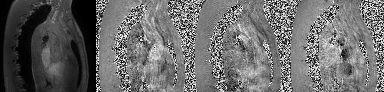

In [101]:
target_magnitude = np.mean(np.abs(target_file['img'][...]),axis=-1)
venc_ref = 1.5
venc = 0.5
target_velocity = np.angle(np.exp(1j*(np.angle(target_file['img'][...,1:])-np.angle(target_file['img'][...,0:1]))*venc_ref/venc))

name = f'geometry_stack_venc_{venc}'

def concatenate_images(data : np.ndarray,index : list) -> np.ndarray:
    carray = data[:,:,index[0],:]
    for i in range(len(index)-1):
        carray = np.concatenate((carray,data[:,:,index[i+1],:]),axis=1)
    return carray

indices = [int((np.max(np.argwhere(target_mask>0.5)[:,2])-np.min(np.argwhere(target_mask>0.5)[:,2]))/2)]
target = concatenate_images(minmaxnorm(target_magnitude),indices)
target = np.concatenate((target, concatenate_images(minmaxnorm(target_velocity[...,0]),indices)),axis=1)
target = np.concatenate((target, concatenate_images(minmaxnorm(target_velocity[...,1]),indices)),axis=1)
target = np.concatenate((target, concatenate_images(minmaxnorm(target_velocity[...,2]),indices)),axis=1)

imageio.mimwrite(f'{name}.gif',np.transpose(np.abs(target),[2,0,1])*255/np.abs(target).max(),duration=1,loop=0)
ipImage(f'{name}.gif',width=600)

In [102]:

mode_list = ['None','lap4D','nprs','gc3D']
vel_ref = target_velocity.copy()
for mode in mode_list:

    target_velocity = np.zeros_like(vel_ref)

    if mode == 'lap4D':
        for kv in range(vel_ref.shape[-1]):
            target_velocity[...,kv]=unwrap_data(vel_ref[...,kv],mode=mode,venc=float(venc),ts=2)

    if mode == 'nprs':
        for kv in range(vel_ref.shape[-1]):
            target_velocity[...,kv]=unwrap_data(vel_ref[...,kv], mask=np.tile(target_mask[...,np.newaxis],25),mode = mode,upsampling_factor=2,pi_unwrap=True,auto_crop=True,tfc=True,venc=float(venc))

    if mode == 'gc3D':
        for kv in range(vel_ref.shape[-1]):
            target_velocity[...,kv] = unwrap_data(vel_ref[...,kv], mask=np.tile(target_mask[...,np.newaxis],25),mode = mode,tfc=True,venc=float(venc))
    
    if mode == 'None':
        for kv in range(vel_ref.shape[-1]):
            target_velocity[...,kv] = np.angle(np.exp(1j*(vel_ref[...,kv])))      

    name = f'target_unwrapping_{mode}_venc_{venc}'
    target_velocity*=target_mask[...,np.newaxis,np.newaxis]

    indices = [int((np.max(np.argwhere(target_mask>0.5)[:,2])-np.min(np.argwhere(target_mask>0.5)[:,2]))/2)]
    target = concatenate_images(minmaxnorm(target_velocity[...,0]),indices)
    target = np.concatenate((target, concatenate_images(minmaxnorm(target_velocity[...,1]),indices)),axis=1)
    target = np.concatenate((target, concatenate_images(minmaxnorm(target_velocity[...,2]),indices)),axis=1)

    imageio.mimwrite(f'{name}.gif',np.transpose(np.abs(target),[2,0,1])*255/np.abs(target).max(),duration=1,loop=0)
    ipImage(f'{name}.gif',width=600)